## **Random Forest Classifier - Final Model & Results**

### **Overview**

This notebook presents the **Random Forest Classifier** for multi-class classification. The model was trained using **hyperparameter tuning**, **5-Fold Cross-Validation**, and various **evaluation metrics** to ensure robustness and high generalization.

---

### **Data Preprocessing & Preparation**

- **Dataset Used**: `final_dataset.csv`
- **Label Encoding**: Converts categorical labels into numerical format.
- **Feature Scaling**: Input features were **normalized** to a `[0, 1]` range for better performance.
- **Stratified Train-Test Split**: Ensures balanced class distribution in both training and testing sets.
- **SMOTETomek Applied**: Balances class distribution to improve model generalization.

---

### **Hyperparameter Tuning**

A **Randomized Search Cross-Validation** approach was used to find the best hyperparameters for Random Forest.

| Hyperparameter                              | Selected Value |
| ------------------------------------------- | -------------- |
| **Number of Trees (`n_estimators`)**        | X              |
| **Max Depth (`max_depth`)**                 | X              |
| **Min Samples Split (`min_samples_split`)** | X              |
| **Min Samples Leaf (`min_samples_leaf`)**   | X              |
| **Max Features (`max_features`)**           | X              |
| **Class Weight**                            | `balanced`     |

The **best hyperparameters** were determined through **50 iterations of Randomized Search**.

---

### **Cross-Validation Results**

The model was evaluated using **5-Fold Stratified Cross-Validation** to measure its generalization capability.

✅ **Mean Cross-Validation Accuracy:** **0.8508% \*\***

The cross-validation results confirm that the **Random Forest model** maintains **consistent performance** across different data splits.

---

### **Final Model Evaluation**

After selecting the best hyperparameters, the **final Random Forest model** was trained and evaluated on the **test set**.

| Metric                        | Value      |
| ----------------------------- | ---------- |
| **Test Accuracy**             | **87.82%** |
| **Train Accuracy**            | **99.76%** |
| **Cross-Validation Accuracy** | **85.08%** |
| **Test Precision**            | **87.73%** |
| **Test Recall**               | **87.82%** |
| **Test F1-Score**             | **87.42%** |


Performing Randomized Search for Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Stratified K-Fold Cross-Validation Results:
CV Scores: [0.85631739 0.85152602 0.84939218 0.85046044 0.84623116]
Mean CV Score: 0.8508
Standard Deviation of CV Scores: 0.0033


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: Unde


Final Model Results on Test Set:
Test Accuracy: 0.8782
Test Precision: 0.8773
Test Recall: 0.8782
Test F1-score: 0.8742
Train Accuracy: 0.9976

Classification Report (Test Set):
                 precision    recall  f1-score   support

       Abundant       0.83      0.95      0.89        21
         Active       0.77      0.95      0.85        21
          Adult       0.95      1.00      0.98        21
          Agile       0.95      0.95      0.95        22
       Alluring       0.87      0.95      0.91        21
        Amiable       0.91      1.00      0.95        21
        Amusing       0.87      1.00      0.93        20
   Aristocratic       1.00      1.00      1.00        22
       Aromatic       0.88      1.00      0.94        22
       Artistic       0.88      1.00      0.94        22
  Authoritative       0.95      1.00      0.98        21
         Bitter       0.88      1.00      0.94        22
        Bitterl       0.92      1.00      0.96        22
           Bold       

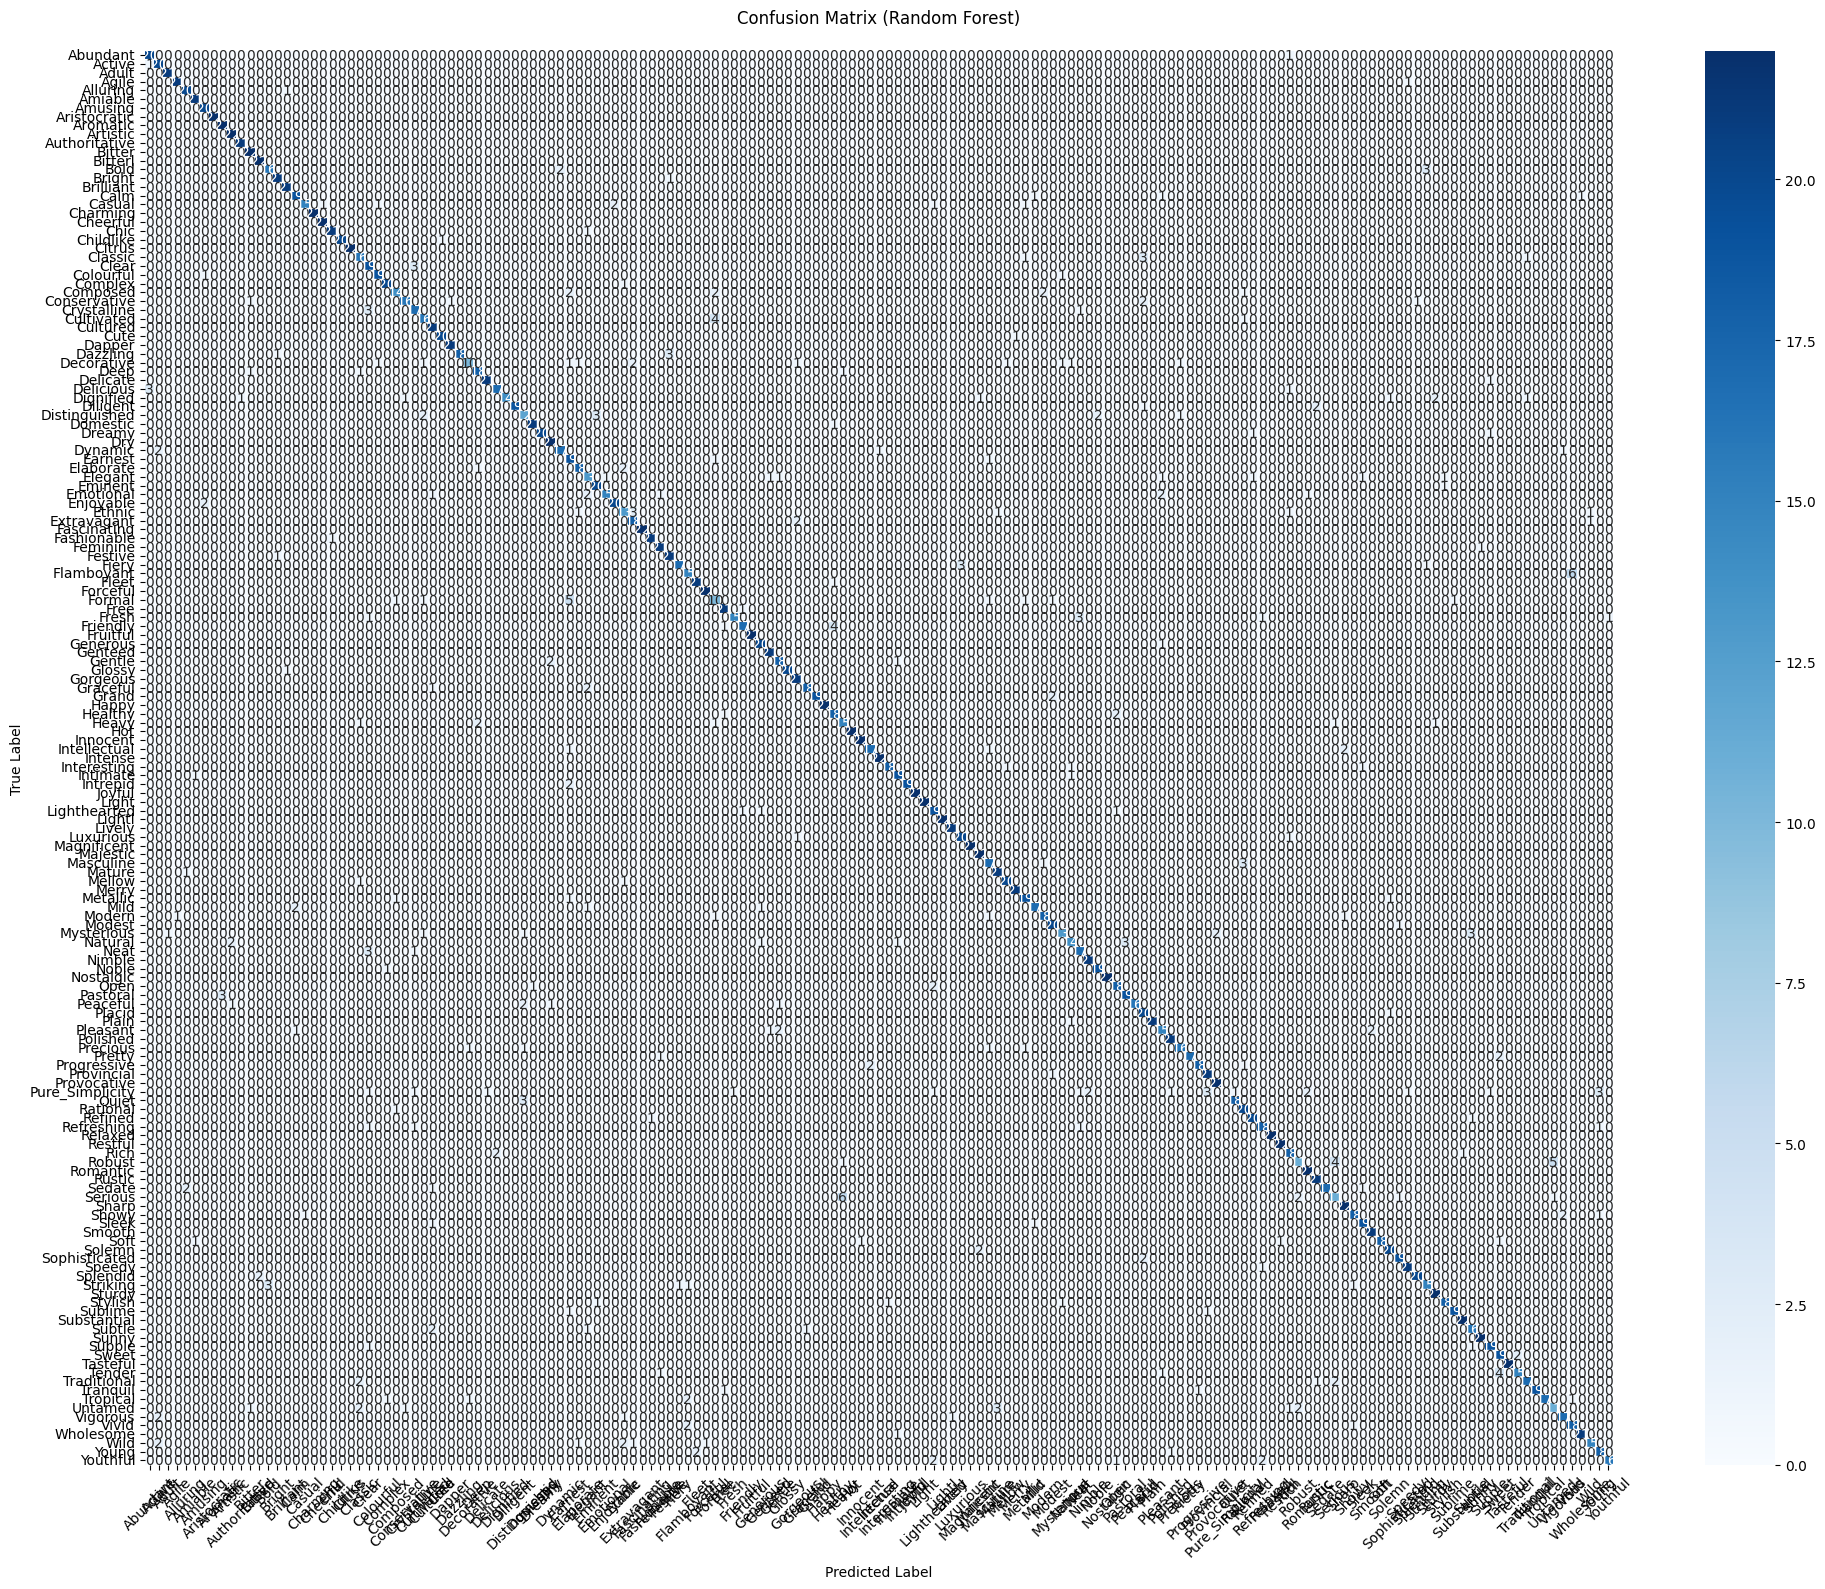

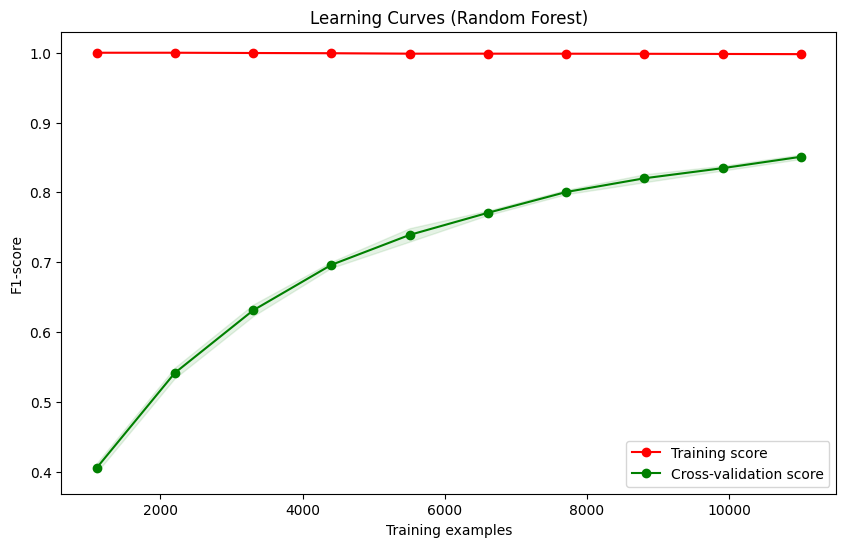

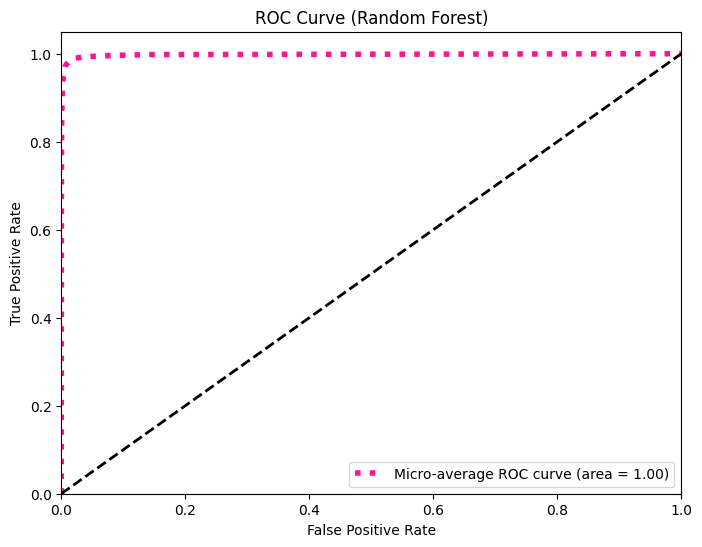

Model saved successfully to ../emotion-predictor/backend/app/model\random_forest_model.pkl


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import os
import pickle
import seaborn as sns
from sklearn.calibration import CalibratedClassifierCV

# 1. Load and preprocess the dataset
data = pd.read_csv('final_dataset.csv')
X = data.iloc[:, :-1].values / 255.0
y = data.iloc[:, -1].values

# Encode the target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 2. Define parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

# 3. Set up RandomizedSearchCV
rf_classifier = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, verbose=2, scoring='f1_weighted', random_state=42)

# 4. Perform Randomized Search to find the best hyperparameters
print("Performing Randomized Search for Random Forest...")
random_search.fit(X_train, y_train)

# 5. Get the best model
best_model = random_search.best_estimator_

# 6. Perform Stratified K-Fold Cross-Validation on the best model
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=skf, scoring='f1_weighted')

# 7. Print cross-validation results
print("\nStratified K-Fold Cross-Validation Results:")
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation of CV Scores: {cv_scores.std():.4f}")

# 8. Fit the model on the entire training set
best_model.fit(X_train, y_train)

# 8+. Calibrate the pipeline using CalibratedClassifierCV
#    Here we use 5-fold for calibration; 'isotonic' typically works well for multi-class
calibrated_RF = CalibratedClassifierCV(
    estimator=best_model, 
    method='isotonic', 
    cv=5
)
calibrated_RF.fit(X_train, y_train)


# 9. Evaluate the final model on the test set and train set
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

# Test Metrics
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='weighted')
test_recall = recall_score(y_test, y_pred_test, average='weighted')
test_f1 = f1_score(y_test, y_pred_test, average='weighted')

# Train Metrics
train_accuracy = accuracy_score(y_train, y_pred_train)

print("\nFinal Model Results on Test Set:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

# 10. Confusion Matrix
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(20, 16))
sns.heatmap(cm, 
            annot=True,        
            fmt='d',           
            cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Confusion Matrix (Random Forest)', pad=20)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 11. Learning Curves
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=skf, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1_macro'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("F1-score")
plt.title("Learning Curves (Random Forest)")
plt.legend(loc="best")
plt.show()

# 12. ROC Curve
y_score = best_model.predict_proba(X_test)
n_classes = len(le.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()

y_bin = np.eye(n_classes)[y_test]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend(loc="lower right")
plt.show()

# 13. Save the model and scaler
model_dir = '../emotion-predictor/backend/app/model'
os.makedirs(model_dir, exist_ok=True)

# Save the model using pickle
model_path = os.path.join(model_dir, 'random_forest_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"Model saved successfully to {model_path}")

# Save the label encoder
le_path = os.path.join(model_dir, 'label_encoder.pkl')
with open(le_path, 'wb') as f:     
    pickle.dump(le, f) 

📌 **Key Observations:**

- The **Test Accuracy (87.82%)** indicates strong generalization.
- The **Training Accuracy (99.76%)** is much higher than the **Cross-Validation Accuracy (85.08%)**, suggesting **slight overfitting**.
- **Precision (87.73%) and Recall (87.82%)** confirm balanced classification performance.
- The **F1-Score (87.42%)** provides a **harmonized evaluation** between Precision and Recall.
